In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt

Select desired values for booleans:

In [2]:
#True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = False

#True if including internal resistance for old data, False if not (no internal resistance variable for new data)
ir = False

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = False

#True if scaling explanatory variables with Robust Scaler, False otherwise (necessary for elastic net)
scaled = False

old_new_scaler = False

if scaled:
    #True if using old and new data scaled separately in combined data, False if using a separate scaler for all combined data
    old_new_scaler = True

#True if using all battery chemistries, False if only LFP
new_chemistries = True

if new_chemistries:
    #True if tracking the sources of the new chemistries, False if not
    chem_sources = True
    
    #Identifies the combined data test set's chemistry, or identifies that there will be all new data or a combination all data
    #Old data will not be used if LFP is selected, but will be used if combination is selected
    test_set = ["combination", "new", "half new", "new unchanged", "LFP", "NCA", "NMC", "old"]
    test_set = test_set[7]
    
else:
    chem_sources = False
    test_set = ["combination", "new", "half new", "new unchanged", "LFP", "old", "half"]
    test_set = test_set[3]

#True if identifying the source of the data (old, new), False if not
sources = True

#True if using new environment variables
environ = True

## Reading in the Data

In [3]:
path = "./features/"

old_d_dir = path + "DeltaQFastCharge/"
old_t_dir = path + "TrajectoryFastCharge/"


def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if ".json" in fullPath:
            allFiles.append(fullPath)
    return allFiles

old_d_list = getListOfFiles(old_d_dir)
old_t_list = getListOfFiles(old_t_dir)

In [4]:
def get_new_names(d_list):
    new_names = []
    for file in d_list:
        new_names.append(re.findall("CH(.*?)\_f", file)[0])
    return new_names

def make_df(file_list, batch=False):
    df = pd.DataFrame()
    for file in file_list:
        with open(file) as data_file:    
            data = json.load(data_file)
            data_df = pd.json_normalize(data)
            df = pd.concat([df,data_df])
    df.reset_index(drop=True,inplace=True)
    if batch:
        df['bat_num'] = get_new_names(file_list)
    return df

def merge_df(d_df, t_df):
    df_full = d_df.merge(t_df, left_index=True, right_index=True)

    # Making values not stored as lists
    for column in df_full.columns:
        if "X." in column:
            df_full[column] = df_full[column].apply(lambda x: x[0])

    df_full.reset_index(inplace=True)
    return df_full

In [5]:
path = "./"
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")

In [6]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [7]:
if environ:
    old_ct["Temperature"] = 30
    old_ct["DOD"] = 100
    old_ct["Discharge_rate"] = 4
    old_ct["Charge_rate"] = 4.8

In [8]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

if new_chemistries:
    nca_df = pd.read_csv(path + "NewData/charge_throughputs_BA_NCA.csv")
    nmc_df = pd.read_csv(path + "NewData/charge_throughputs_BA_NMC.csv")
    
    chemistries = ["LFP", "NCA", "NMC"]
    dfs = [new_ct, nca_df, nmc_df]
    
    for i in range(len(chemistries)):
        chem = chemistries[i]
        for j in range(len(dfs)):
            df = dfs[j]
            
            if i == j:
                df[chem] = 1
            else:
                df[chem] = -1
            
            dfs[j] = df
        
    new_ct = pd.concat([df for df in dfs], ignore_index=True)

Models

In [9]:
variance_model_features = ['X.abs_variance_discharge_capacity_difference_cycles_2:100']
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')
    
if environ:
    variance_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))
    discharge_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))
    full_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [10]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler

## Old Data

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='charge_throughput'>

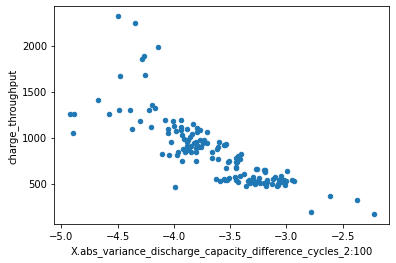

In [11]:
old_ct.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = y)

#### Our split (odds to train, evens to test):

#### TRI Split:

In [12]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

In [13]:
if scaled:
    
    all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))
    
    def scale(train, test):
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        return [train_data, test_data]
    
    if old_new_scaler:
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]
        temp_test_ind = list(set(old_ct.index)-set(train_ind))
        X_test_all_old = old_ct.iloc[temp_test_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old, X_test_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]
        X_test_all_old[y] = old_ct.iloc[temp_test_ind][y]

        X_all_old = X_train_all_old.append(X_test_all_old)
        
        X_test_all_old = X_test_all_old.iloc[test_ind]

### Variance Model [Old Data]

In [14]:
# Variance model
X_train_var = old_ct.iloc[train_ind][variance_model_features]

y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][variance_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_var, X_test_var = scale(X_train_var, X_test_var)

In [15]:
reg_var = RandomForestRegressor(criterion='mae').fit(X_train_var, np.ravel(y_train))

y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Random Forest Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Random Forest Model
Test RMSE:  215.07189362081277
Mean % Test Error:  15.63158223312695


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

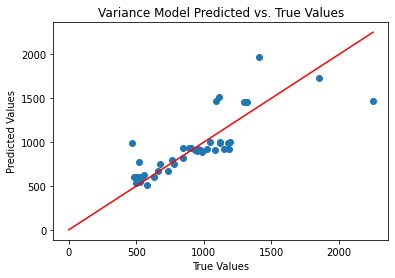

In [16]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

#### From paper (Variance Model)
* Training RMSE: 103
* Test RMSE: 138
* Mean % Train Error: 14.1
* Mean % Test Error: 14.7

### Discharge Model [Old Data]

In [17]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)

reg_dis = RandomForestRegressor(criterion='mae').fit(X_train_dis,np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Random Forest Model")
# print("Training RMSE: ", rmse_train_dis)
print("Test RMSE: ", rmse_test_dis)
# print("Train Mean % Error: ", mape_train_dis)
print("Test Mean % Error: ", mape_test_dis)

Discharge Random Forest Model
Test RMSE:  211.23602911742702
Test Mean % Error:  13.519109881080258


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

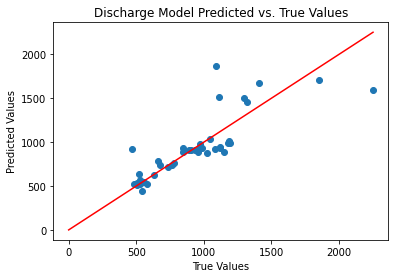

In [18]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

#### From paper (Discharge Model)
* Training RMSE: 76
* Test RMSE: 91
* Mean % Train Error: 9.8
* Mean % Test Error: 13.0

### Full Model [Old Data]

In [19]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_full, X_test_full = scale(X_train_full, X_test_full)

reg_full = RandomForestRegressor(criterion='mae').fit(X_train_full,np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Random Forest Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", rmse_test_full)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mape_test_full)

Full Random Forest Model
Test RMSE:  212.32752742915494
Mean % Test Error:  14.076262315083321


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

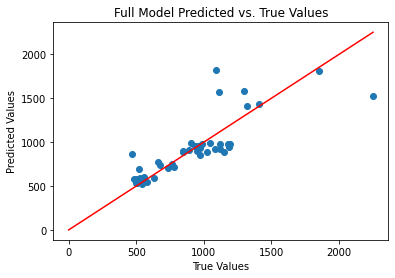

In [20]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

#### From paper (Full Model)
* Training RMSE: 51
* Test RMSE: 118
* Mean % Train Error: 5.6
* Mean % Test Error: 14.1

### Old Data Plots

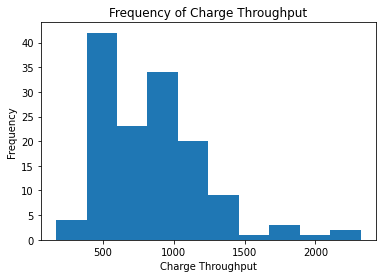

In [21]:
plt.hist(old_ct[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life')

In [22]:
old_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Test MAPE": [mape_test_var,
                                              mape_test_dis,
                                              mape_test_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'Old Data Test RMSE Comparison')

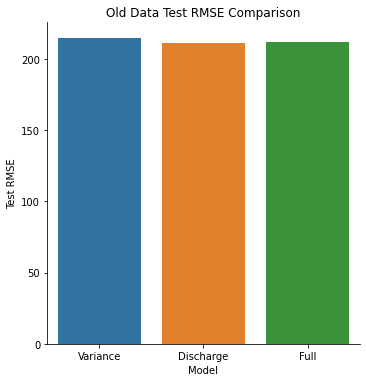

In [23]:
sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("Old Data Test RMSE Comparison")

Text(0.5, 1.0, 'Old Data Test MAPE Comparison')

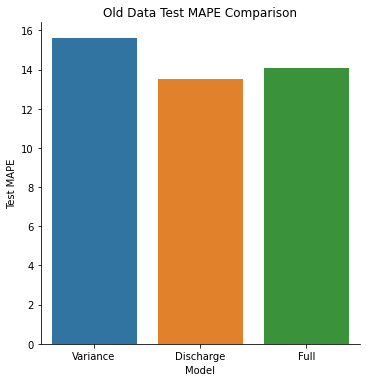

In [24]:
sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = "Test MAPE")
plt.title("Old Data Test MAPE Comparison")

In [25]:
#Removing internal_resistance features for models with new data
if ir:
    full_model_features.remove('X.min_internal_resistance_cycles_2:100')
    full_model_features.remove('X.internal_resistance_difference_cycles_2:100')
    
    if scaled:
        all_model_features.remove('X.min_internal_resistance_cycles_2:100')
        all_model_features.remove('X.internal_resistance_difference_cycles_2:100')

## New Data

In [26]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

if new_chemistries:
    nca = pd.read_csv(path + "NewData/NCABatteries.csv")
    nmc = pd.read_csv(path + "NewData/NMCBatteries.csv")
    
    new_df = pd.concat([new_df, nca, nmc], ignore_index=True)
    
    chemistries = ["X.LFP", "X.NCA", "X.NMC"]
    
    if chem_sources:
        variance_model_features = variance_model_features + chemistries
        discharge_model_features = discharge_model_features + chemistries
        full_model_features = full_model_features + chemistries

In [27]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_index=True)
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))

In [28]:
new_ct_full['charge_throughput'].max()

8109.346

In [29]:
train_ind = [i for i in range(1, len(new_ct_full), 2)]
test_ind = [i for i in range(0, len(new_ct_full), 2)]

new_test_ind = test_ind

In [30]:
if scaled:
    if old_new_scaler:
        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)

### Variance Model [New Data]

In [31]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_var.index][[y]]

if scaled:
    X_train_var, X_test_var = scale(X_train_var, X_test_var)

In [32]:
reg_var = RandomForestRegressor(criterion='mae').fit(X_train_var, np.ravel(y_train))
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Random Forest Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Random Forest Model
Test RMSE:  840.8290462700622
Mean % Test Error:  24.35838445113976


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR)')

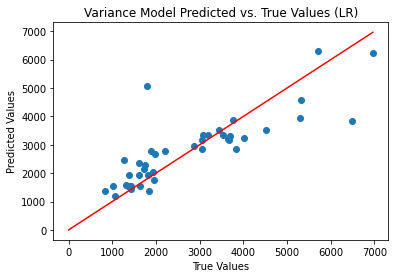

In [33]:
# Linear Regression
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR)")

### Discharge Model [New Data]

In [34]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan)
X_train_dis.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf], np.nan)
X_test_dis.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

if scaled:
    X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)

reg_dis = RandomForestRegressor(criterion='mae').fit(X_train_dis, np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Random Forest Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", rmse_test_dis)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mape_test_dis)

Discharge Random Forest Model
Test RMSE:  778.3935761377236
Mean % Test Error:  24.126468624474544


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR)')

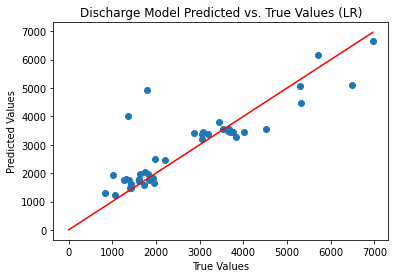

In [35]:
# Linear Regression
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR)")

### Full Model [New Data]

In [36]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features].replace([np.inf, -np.inf], np.nan)
X_train_full.dropna(axis=0, inplace=True) 
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features].replace([np.inf, -np.inf], np.nan)
X_test_full.dropna(axis=0, inplace=True) 
y_test = new_ct_full.iloc[X_test_full.index][[y]]

if scaled:
    X_train_full, X_test_full = scale(X_train_full, X_test_full)

reg_full = RandomForestRegressor(criterion='mae').fit(X_train_full, np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Random Forest Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", rmse_test_full)
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mape_test_full)

Full Random Forest Model
Test RMSE:  885.6699971546478
Mean % Test Error:  22.957526183556315


In [37]:
y_test.max()

charge_throughput    6965.715
dtype: float64

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (RF) [New Data]')

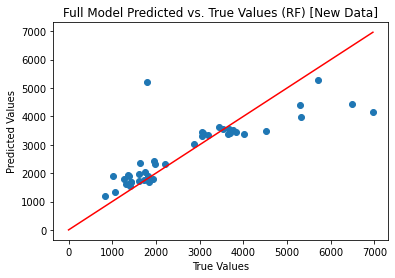

In [38]:
#Linear Regression
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (RF) [New Data]")

### New Data Plots

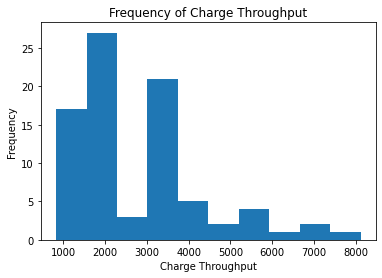

In [39]:
plt.hist(new_ct_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life (New Data)')

In [40]:
new_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Test MAPE": [mape_test_var,
                                              mape_test_dis,
                                              mape_test_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'New Data Test RMSE Comparison')

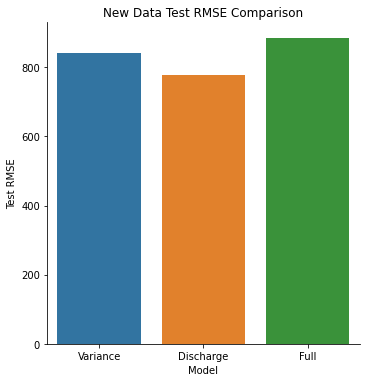

In [41]:
sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("New Data Test RMSE Comparison")

Text(0.5, 1.0, 'New Data Test MAPE Comparison')

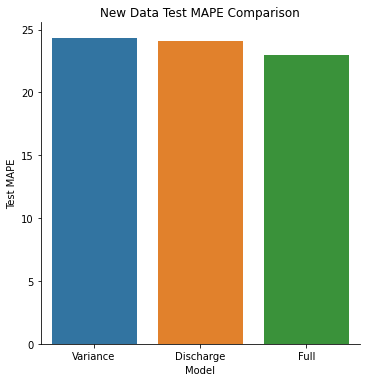

In [42]:
sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = "Test MAPE")
plt.title("New Data Test MAPE Comparison")

## Combined (Old+New) Data

In [43]:
new_ct_full.shape

(83, 36)

In [44]:
old_ct.shape

(139, 49)

In [45]:
variance_model_features = variance_model_features[:-3]
discharge_model_features = discharge_model_features[:-3]
full_model_features = full_model_features[:-3]

In [46]:
if scaled:
    
    all_model_features = variance_model_features
    
    def scale(train, test=pd.DataFrame()):
        #print(type(test))
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        if len(test) != 0:
            test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        else:
            test_data = 0
        return [train_data, test_data]
    
    if old_new_scaler:
        # old
        train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]

        X_all_old = X_train_all_old

        # new
        train_ind = [i for i in range(0, len(new_ct_full), 2)]
        test_ind = [i for i in range(1, len(new_ct_full), 2)]

        new_test_ind = test_ind

        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)

In [47]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1
    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

if new_chemistries & chem_sources:
    old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
    old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
    old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]
    variance_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    discharge_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    full_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))

In [48]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [49]:
if scaled:
    if old_new_scaler:
        if sources:
            X_all_old["Source"] = -1
            X_all_new["Source"] = 1
            all_model_features.append("Source")
            
        if new_chemistries & chem_sources:
            X_all_old["X.LFP"] = 1
            X_all_old["X.NCA"] = -1
            X_all_old["X.NMC"] = -1

            for chem in chemistries:
                X_all_new[chem].replace(0, -1, inplace=True)
            
        full_data = X_all_old.append(X_all_new)
        full_data = full_data.reset_index()

In [50]:
if new_chemistries:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)
            
    elif test_set == "NCA":
        test_ind = list(full_data[full_data["X.NCA"] > 0].index)
        
    elif test_set == "NMC":
        test_ind = list(full_data[full_data["X.NMC"] > 0].index)
        
    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
    
else:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)

    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
        
train_ind = list(set(full_data.index) - set(test_ind))
#train_ind = list(full_data.iloc[:84].index) + [j for j in range(139, len(full_data),2)]

### Variance Model

In [51]:
# Variance model
X_train_var = full_data.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_var.index][[y]]

X_test_var = full_data.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_var.index][[y]]

if scaled:
    X_train_var, X_test_var = scale(X_train_var, X_test_var)

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [52]:
reg_var = RandomForestRegressor(criterion='mae').fit(X_train_var, np.ravel(y_train))
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_var = np.exp(y_pred_train_var)
    y_pred_test_var = np.exp(y_pred_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Test RMSE:  187.1016131283936
Mean % Test Error:  17.40762019920834


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

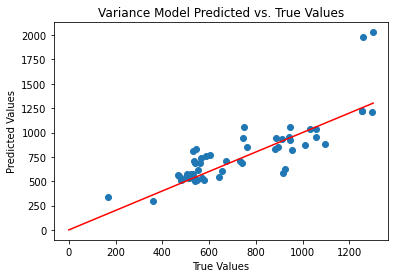

In [53]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

### Discharge Model

In [54]:
variance_model_features = variance_model_features[:-4]
discharge_model_features = discharge_model_features[:-4]
full_model_features = full_model_features[:-4]

In [55]:
if scaled:
    
    all_model_features = discharge_model_features
    
    def scale(train, test=pd.DataFrame()):
        #print(type(test))
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        if len(test) != 0:
            test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        else:
            test_data = 0
        return [train_data, test_data]
    
    if old_new_scaler:
        # old
        train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]

        X_all_old = X_train_all_old

        # new
        train_ind = [i for i in range(0, len(new_ct_full), 2)]
        test_ind = [i for i in range(1, len(new_ct_full), 2)]

        new_test_ind = test_ind

        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)  

In [56]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1
    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

if new_chemistries & chem_sources:
    old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
    old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
    old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]
    variance_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    discharge_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    full_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))

In [57]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [58]:
if scaled:
    if old_new_scaler:
        if sources:
            X_all_old["Source"] = -1
            X_all_new["Source"] = 1
            all_model_features.append("Source")
            
        if new_chemistries & chem_sources:
            X_all_old["X.LFP"] = 1
            X_all_old["X.NCA"] = -1
            X_all_old["X.NMC"] = -1

            for chem in chemistries:
                X_all_new[chem].replace(0, -1, inplace=True)
            
        full_data = X_all_old.append(X_all_new)
        full_data = full_data.reset_index()

In [59]:
if new_chemistries:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)
            
    elif test_set == "NCA":
        test_ind = list(full_data[full_data["X.NCA"] > 0].index)
        
    elif test_set == "NMC":
        test_ind = list(full_data[full_data["X.NMC"] > 0].index)
        
    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
    
else:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)

    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
        
train_ind = list(set(full_data.index) - set(test_ind))
#train_ind = list(full_data.iloc[:84].index) + [j for j in range(139, len(full_data),2)]

In [64]:
# if environ:
#     discharge_model_features.remove("Temperature")
#     discharge_model_features.remove("DOD")
#     discharge_model_features.remove("Discharge_rate")
#     discharge_model_features.remove("Charge_rate")

X_train_dis = full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_dis = full_data.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)

# if environ:
#     discharge_model_features.extend(("Temperature", "DOD", "Discharge_rate", "Charge_rate"))
#     X_train_dis = full_data.iloc[X_train_dis.index][discharge_model_features]
#     X_test_dis = full_data.iloc[X_test_dis.index][discharge_model_features]
    
X_train_dis.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_dis.index][[y]]

if scaled:
    if not old_new_scaler:
        X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)
    
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [66]:
reg_dis = RandomForestRegressor(criterion='mae').fit(X_train_dis, np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_dis = np.exp(y_pred_train_dis)
    y_pred_test_dis = np.exp(y_pred_test_dis)

In [67]:
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Test RMSE:  188.22042790632938
Mean % Test Error:  0.13863853077679072


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

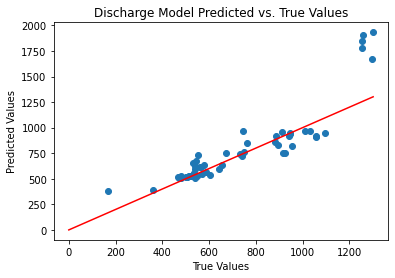

In [68]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

In [69]:
feature_names = []
for i in X_train_dis.columns:
    out = i
    if "X." in i:
        out = out.replace("X.", "")
    if "_" in out:
        out = out.replace("_", " ")
    feature_names.append(out)

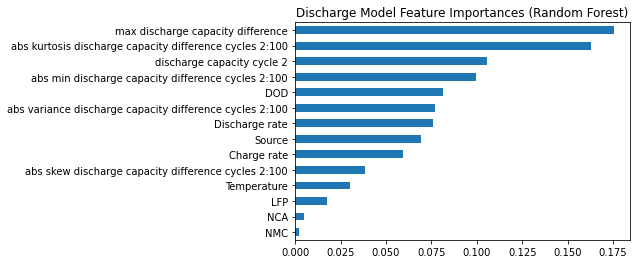

In [70]:
dfi = {'feature': feature_names, 'feature importance' : reg_dis.feature_importances_}
df_feature_importances = pd.DataFrame(data=dfi, index = feature_names)

ax = df_feature_importances.sort_values(by='feature importance',ascending=False).plot.barh(align='center')
plt.title("Discharge Model Feature Importances (Random Forest)")
ax.invert_yaxis()
ax.get_legend().remove()

### Full Model [Combined Data]

In [71]:
variance_model_features = variance_model_features[:-4]
discharge_model_features = discharge_model_features[:-4]
full_model_features = full_model_features[:-4]

In [72]:
if scaled:
    
    all_model_features = full_model_features
    
    def scale(train, test=pd.DataFrame()):
        #print(type(test))
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        if len(test) != 0:
            test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        else:
            test_data = 0
        return [train_data, test_data]
    
    if old_new_scaler:
        # old
        train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]

        X_all_old = X_train_all_old

        # new
        train_ind = [i for i in range(0, len(new_ct_full), 2)]
        test_ind = [i for i in range(1, len(new_ct_full), 2)]

        new_test_ind = test_ind

        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)  

In [73]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1
    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

if new_chemistries & chem_sources:
    old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
    old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
    old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]
    variance_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    discharge_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    full_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))

In [74]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [75]:
if scaled:
    if old_new_scaler:
        if sources:
            X_all_old["Source"] = -1
            X_all_new["Source"] = 1
            all_model_features.append("Source")
            
        if new_chemistries & chem_sources:
            X_all_old["X.LFP"] = 1
            X_all_old["X.NCA"] = -1
            X_all_old["X.NMC"] = -1

            for chem in chemistries:
                X_all_new[chem].replace(0, -1, inplace=True)
            
        full_data = X_all_old.append(X_all_new)
        full_data = full_data.reset_index()

In [76]:
if new_chemistries:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)
            
    elif test_set == "NCA":
        test_ind = list(full_data[full_data["X.NCA"] > 0].index)
        
    elif test_set == "NMC":
        test_ind = list(full_data[full_data["X.NMC"] > 0].index)
        
    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
    
else:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)

    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
        
train_ind = list(set(full_data.index) - set(test_ind))
#train_ind = list(full_data.iloc[:84].index) + [j for j in range(139, len(full_data),2)]

In [77]:
X_train_full = full_data.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_full = full_data.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
    
X_train_full.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_full.index][[y]]

X_test_full.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_full.index][[y]]

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [78]:
reg_full = RandomForestRegressor(criterion='mae').fit(X_train_full,np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_full = np.exp(y_pred_train_full)
    y_pred_test_full = np.exp(y_pred_test_full)

In [79]:
rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Test RMSE:  199.4686923973484
Mean % Test Error:  0.16758180829997002


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (RF) [Combined Data]')

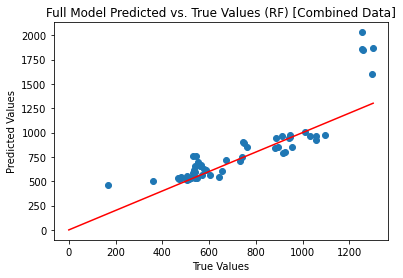

In [80]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (RF) [Combined Data]")

In [81]:
feature_names = []
for i in X_train_full.columns:
    out = i
    if "X." in i:
        out = out.replace("X.", "")
    if "_" in out:
        out = out.replace("_", " ")
    feature_names.append(out)

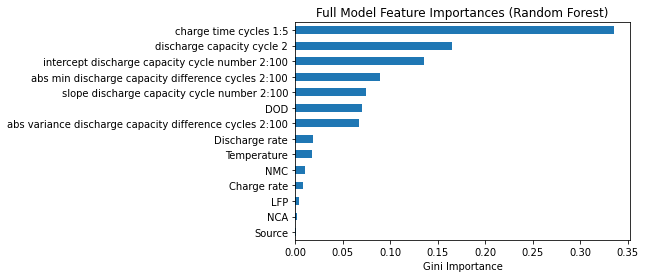

In [83]:
dfi = {'feature': feature_names, 'feature importance' : reg_full.feature_importances_}
df_feature_importances = pd.DataFrame(data=dfi, index = feature_names)

ax = df_feature_importances.sort_values(by='feature importance',ascending=False).plot.barh(align='center')
plt.title("Full Model Feature Importances (Random Forest)")
ax.invert_yaxis()
plt.xlabel("Gini Importance")
ax.get_legend().remove()

## Old + New Data Plots

/home/steven/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


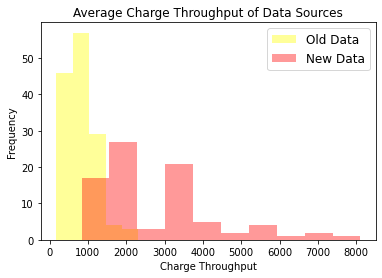

In [84]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=10)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

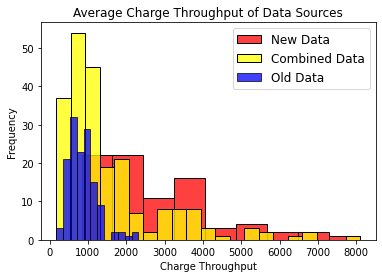

In [85]:
sns.histplot(new_ct_full[y], color="red", label='New Data')
sns.histplot(full_data[y], color = "yellow", label = 'Combined Data')
sns.histplot(old_ct[y], color="blue", label='Old Data')


# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

In [86]:
all_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Test MAPE": [mape_test_var,
                                              mape_test_dis,
                                              mape_test_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'Combined Data Test RMSE Comparison')

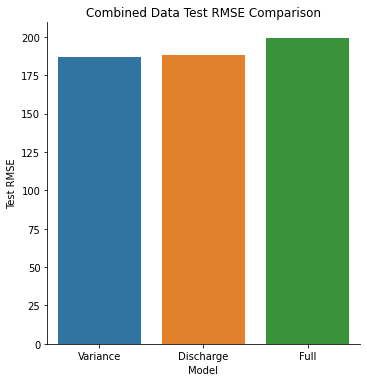

In [87]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("Combined Data Test RMSE Comparison")

Text(0.5, 1.0, 'Combined Data Test MAPE Comparison')

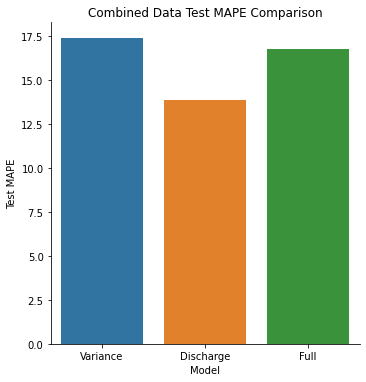

In [88]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Test MAPE")
plt.title("Combined Data Test MAPE Comparison")

In [89]:
all_data_metrics['Data'] = 'Combined'
new_data_metrics['Data'] = 'New'
old_data_metrics['Data'] = 'Old'

In [90]:
entire_data_metrics = pd.concat([old_data_metrics,new_data_metrics,all_data_metrics]).reset_index()
# entire_data_metrics = pd.concat([new_data_metrics,all_data_metrics]).reset_index()

(0.0, 35.0)

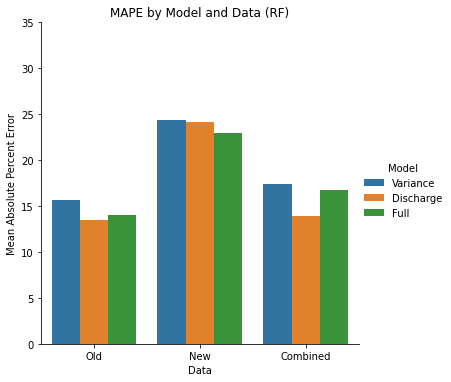

In [91]:
sns.catplot(data = entire_data_metrics, kind="bar",
               x = "Data", y = "Test MAPE",hue = 'Model')
plt.title("MAPE by Model and Data (RF)")
plt.ylabel("Mean Absolute Percent Error")
plt.ylim(0, 35)